<a href="https://colab.research.google.com/github/xHeput/neural_networks/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('pollution.csv')

# Check for NaNs and handle them
print(df.isna().sum())
df = df.dropna()  # Drop rows with NaN values

# Apply label encoding to the 'cbwd' column
le_cbwd = LabelEncoder()
df['cbwd'] = le_cbwd.fit_transform(df['cbwd'])

# Select features and target variable
features = df[['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']]
target = df['pm2.5']

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Verify normalization
print(features_scaled.min(), features_scaled.max())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Print shapes after train-test split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Generate sequences
window_size = 10  # To Adjust
X_train_seq = []
y_train_seq = []

for i in range(len(X_train) - window_size):
    if i + window_size < len(y_train):
        X_train_seq.append(X_train[i:i+window_size])
        y_train_seq.append(y_train.iloc[i+window_size])

X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")


X_test_seq = []
y_test_seq = []

for i in range(len(X_test) - window_size):
    if i + window_size < len(y_test):
        X_test_seq.append(X_test[i:i+window_size])
        y_test_seq.append(y_test.iloc[i+window_size])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

# Reshape input data for LSTM layer
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])




In [ ]:
# Define the model with a lower learning rate
def create_model():
    model = Sequential([
        LSTM(64, input_shape=(window_size, X_train_seq.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if necessary
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create and train the model
model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


# Evaluate the model
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {loss}')

261/261 [==============================] - 3s 7ms/step


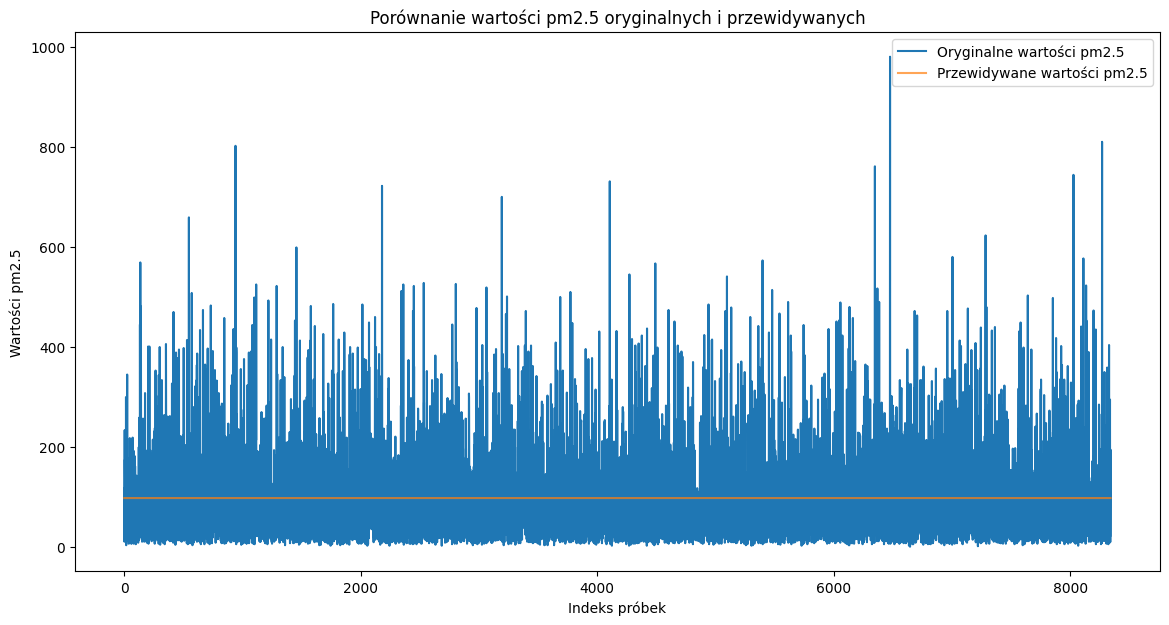

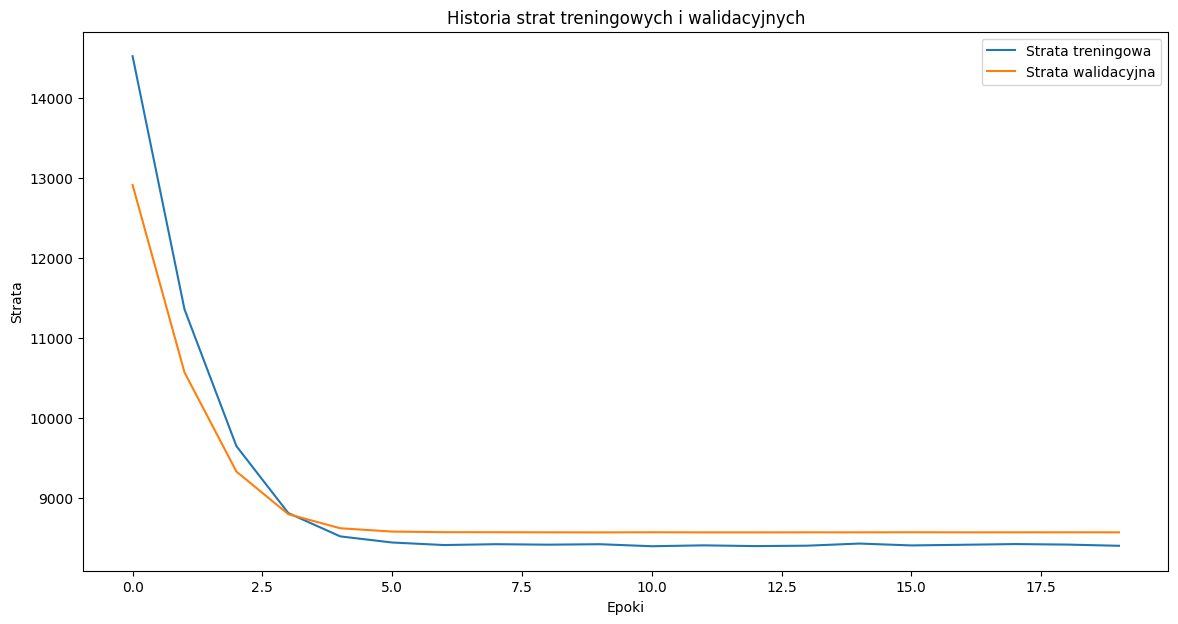

In [38]:
import matplotlib.pyplot as plt

# Przewidywanie wartości pm2.5 na danych testowych
y_pred = model.predict(X_test_seq)

# Wykres porównujący oryginalne i przewidywane wartości pm2.5
plt.figure(figsize=(14, 7))
plt.plot(y_test_seq, label='Oryginalne wartości pm2.5')
plt.plot(y_pred, label='Przewidywane wartości pm2.5', alpha=0.7)
plt.title('Porównanie wartości pm2.5 oryginalnych i przewidywanych')
plt.xlabel('Indeks próbek')
plt.ylabel('Wartości pm2.5')
plt.legend()
plt.show()

# Wykres strat treningowych i walidacyjnych
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Historia strat treningowych i walidacyjnych')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
